## Field Maps で取得したトラックを指定日時でクエリし、フィーチャ レイヤー（Feature Layer）として保存する

ArcGIS API for Python を使用した位置のトラッキング機能の管理方法やデータへのアクセス方法は、Help の[Guide](https://developers.arcgis.com/python/guide/) ページのうち、[Managing ArcGIS applications - Configuring Location Tracking](https://developers.arcgis.com/python/guide/configuring-location-tracking-and-track-views/) に説明が書かれています。


同じものが[GitHub にノートブック](https://github.com/Esri/arcgis-python-api/blob/master/guide/13-managing-arcgis-applications/configuring-location-tracking-and-track-views.ipynb) として、さらに[翻訳したノートブック](https://github.com/EsriJapan/arcgis-python-api/blob/master/guide/13-managing-arcgis-applications/configuring-location-tracking-and-track-views_ja.ipynb) を公開しています。  

*注意事項）*  
* このノートブックは、ArcGIS Online 上のArcGIS Notebook を利用して書いたものをエクスポートしたものです。  
* そのため、本ノートブックをご自身の組織のArcGIS Online にアイテム登録して利用いただく事も可能ですが、フィーチャ レイヤー（Feature Layer）として保存する場合は、ノートブック ランタイムでAdvanced 以上が必要となります（Standard のランタイムで実行した場合は、当該箇所はエラーになります）。  
* ArcGIS Online 上のArcGIS Notebook のライセンス切り替えは、アイテム詳細から、[設定]タブを選択し、[Notebook]のセクションで[ノートブックの設定] から行うことが可能です。

### 0) 最初に、自分の組織の GIS モジュールへ接続するには、このセルを実行する必要があります。

※以下のセルは、ArcGIS Online 上のArcGIS Notebook を新規作成時に自動的に生成され、GIS モジュールにアクセスするものですので、そのまま利用します。  
実行環境がArcGIS Online 上のArcGIS Notebook でない場合は、不要な記述です。

In [1]:
from arcgis.gis import GIS
gis = GIS("home")

ここから自分で必要なコードを書きます!
###  1) Field Maps で取得したトラックデータへアクセス

組織の管理者は `LocationTrackingManager` から位置のトラッキング を設定することができます。

※以下のセルでは、[翻訳したノートブック](https://github.com/EsriJapan/arcgis-python-api/blob/master/guide/13-managing-arcgis-applications/configuring-location-tracking-and-track-views_ja.ipynb) からコピーしてきたものから、ArcGIS Online 上のArcGIS Notebook で不要な箇所を、コメントアウトしています。

In [2]:
#from arcgis.gis import GIS # ArcGIS Online の Notebook から呼び出しているのでコメントアウト 
from arcgis.apps.tracker import TrackView

#gis = GIS(profile="your_enterprise_portal") # ArcGIS Online の Notebook から呼び出しているのでコメントアウト
# or 
#gis = GIS("https://arcgis.com", "<username>", "<password>") # ArcGIS Online の Notebook から呼び出しているのでコメントアウト 
location_tracking = gis.admin.location_tracking

位置のトラッキング は、`有効`, `停止`, `無効` の3つの状態があります。それにより、位置のトラッキング の状態を簡単に確認することができます。

In [3]:
# 有効化されているかどうかの確認
location_tracking.status

'enabled'

位置のトラッキング が有効化されると `位置トラッキング サービス`という新しいアイテムが作成されます。モバイル ユーザーは誰でもこのサービスにトラックをアップロードすることができます。このアイテムには、`LocationTrackingManager`オブジェクトを使って簡単にアクセスできます。  
（UIの、[設定] - [組織エクステンション] - [トラッキング中の位置] で有効化に相当します）

<Item title:"位置のトラッキング" type:Feature Layer Collection owner:user@devadmin>
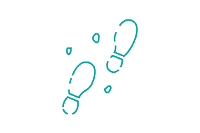

In [4]:
# itemの確認
location_tracking.item

`位置トラッキング サービス` は2つのレイヤーで構成されています。最初のレイヤーである`Tracks` は、各ユーザーの過去の位置情報の履歴を保存します。2つ目のレイヤーである`Last Known Locations` は、Field Maps 等のTracker モバイル アプリ を利用している各ユーザーの最新の位置情報を格納します。これらのレイヤーには`LocationTrackingManager` を通して簡単にアクセスできます。

In [5]:
# Tracks レイヤー はプロパティからアクセス可能
tracks = location_tracking.tracks_layer
tracks

<FeatureLayer url:"https://locationservices7.arcgis.com/pwZze9ckKnvxPvfm/arcgis/rest/services/location_tracking/FeatureServer/0">

In [6]:
# Last Known Locations レイヤー はプロパティからアクセス可能
last_known_locations = location_tracking.last_known_locations_layer
last_known_locations

<FeatureLayer url:"https://locationservices7.arcgis.com/pwZze9ckKnvxPvfm/arcgis/rest/services/location_tracking/FeatureServer/1">

### 2) Tracks レイヤー （Feature Layer）から location_timestamp フィールドで日付と時間を指定してクエリ
Tracks に記録されている時間はUTCなので、クエリをする際に変換して考える必要があります。  
（UTC時間とJSTの時間はJST時間から -9時間を設定します）  

例）FieldMaps で位置のトラッキングした今回の例  
開始;JST 2022年01月10日の15時30分  
終了;JST 2022年01月10日の19時  

a) 最初に、MapViewer での [location_timestamp] フィールドを使って時間指定のクエリ式をブラウザの開発ツール等で確認してみると、

* MapViewer のUIからのフィルタ指定を"2022年01月10日"であると指定した場合

* REST でリクエストされている where句 は  
 (location_timestamp BETWEEN timestamp '2022-01-09 15:00:00' AND timestamp '2022-01-10 14:59:59') AND (1=1)

※UIで指定した条件をWebアプリ（今回はMapViewer）側でUTC時間 に変換した後に、その条件をクエリ式にしてデータを抽出している事が確認できます。

b) 今回のField Maps で位置のトラッキングをした例 だと、次のようなUTC時間での条件式になるはず  
(location_timestamp BETWEEN timestamp '2022-01-10 06:30:00' AND timestamp '2022-01-10 10:00:00') AND (1=1)

In [7]:
wh = "(location_timestamp BETWEEN timestamp '2022-01-10 06:30:00' AND timestamp '2022-01-10 10:00:00') AND (1=1)"

query_tracks = tracks.query(where = wh, out_fields='*').sdf #FeatureLayer.query() の戻り値はFeatureSet、 FeatureSetプロパティsdfでSEDFを取得
query_tracks.head()

,objectid,globalid,activity,altitude,app_id,battery_percentage,battery_state,course,device_id,floor,...,signal_strength,speed,vertical_accuracy,full_name,category,created_user,created_date,last_edited_user,last_edited_date,SHAPE
0,16059,9aa1cd93-16b8-4b19-a974-ff4afeb40eea,2,50.200001,fieldmaps,93,1,332.476776,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.934722,1.335360,user@dev,None,user@devadmin,2022-01-10 07:08:43.236999989,user@devadmin,2022-01-10 07:08:43.236999989,"{""x"": 139.49058310000007, ""y"": 35.897863200000..."
1,16063,2072c156-d06b-49da-ba3e-982fb843bbc5,2,49.800003,fieldmaps,93,1,328.811218,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.660545,1.268793,user@dev,None,user@devadmin,2022-01-10 07:08:43.236999989,user@devadmin,2022-01-10 07:08:43.236999989,"{""x"": 139.49045230000002, ""y"": 35.898036600000..."
2,16072,5bb3f06f-86a5-48db-88f4-a789e3b1934e,2,51.000000,fieldmaps,93,1,322.486725,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.421032,1.276137,user@dev,None,user@devadmin,2022-01-10 07:08:43.236999989,user@devadmin,2022-01-10 07:08:43.236999989,"{""x"": 139.4900851000001, ""y"": 35.8983749000000..."
3,16077,8d1147dc-b459-4029-a0e1-900eaa86bde8,2,50.500000,fieldmaps,93,1,325.728638,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.600265,1.292899,user@dev,None,user@devadmin,2022-01-10 07:08:43.236999989,user@devadmin,2022-01-10 07:08:43.236999989,"{""x"": 139.48994730000004, ""y"": 35.898597200000..."
4,16087,c6c2ef8b-4a83-4e3d-aa54-935c8944b4d8,2,51.500000,fieldmaps,93,1,271.130463,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.289062,1.487937,user@dev,None,user@devadmin,2022-01-10 07:08:43.236999989,user@devadmin,2022-01-10 07:08:43.236999989,"{""x"": 139.4894686, ""y"": 35.89861580000007, ""sp..."


### 3) クエリしたデータをフィーチャ レイヤー（Feature Layer）として保存

Spatially Enabled DataFrame（SEDF）に、to_featurelayer() という便利なメソッドがあるので、それを利用して、フィーチャ レイヤーとして保存します。

※このノートブックでは、この後、別のアプローチやPandas のDataFrame でよく行う操作、グラフ表示や地図表示を試しているため、コメントアウトしています。

In [ ]:
#lyr = query_tracks.spatial.to_featurelayer(title='tracks_20220110', tags='tracks') # FeatureLayer として2022年1月10日のトラックを保存

### 2)' 別のアプローチ ; Tracks レイヤーをPandas のDateFrame で条件抽出
#### Pandas のDataFrame に読み込みしてから location_timestamp フィールドで条件抽出
2) での時間指定 timestamp 'YYYY-MM-DD hh:mm:ss' のかわりに、  
datetime.datetime(year, month, day, hour, minute, second) を使って条件抽出を行います。

In [8]:
# Spatially Enabled DataFrame (SEDF) にTracks レイヤー を読み込みます
import pandas as pd
sdf = pd.DataFrame.spatial.from_layer(tracks)

In [9]:
sdf.tail()

,objectid,globalid,activity,altitude,app_id,battery_percentage,battery_state,course,device_id,floor,...,signal_strength,speed,vertical_accuracy,full_name,category,created_user,created_date,last_edited_user,last_edited_date,SHAPE
1576,17509,aa0b690b-2a14-44b9-816e-a020f939dc0e,2,55.000000,fieldmaps,78,1,134.404556,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,2.152627,1.626806,user@dev,None,user@devadmin,2022-01-10 09:11:49.628,user@devadmin,2022-01-10 09:11:49.628,"{""x"": 139.48831530000007, ""y"": 35.900036400000..."
1577,17575,c4297527-2839-4307-ad4b-2be34a3c9065,2,50.100002,fieldmaps,78,1,138.148727,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,2.221127,1.349059,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.4904646000001, ""y"": 35.8979712000000..."
1578,17578,e4bdcd6c-f04f-4689-965d-7a166c082942,2,50.100002,fieldmaps,78,1,138.904175,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,2.364749,1.247079,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.4905658, ""y"": 35.897844400000054, ""s..."
1579,17593,4023bcb6-4342-4bc9-b2e7-40357a8f80eb,2,49.700001,fieldmaps,78,1,52.776791,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.541021,1.315971,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.49102270000003, ""y"": 35.897557500000..."
1580,17589,80d4aa20-ffb4-470a-8038-7e3d8d0a1fc3,2,50.400002,fieldmaps,78,1,107.498512,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.185419,1.238338,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.49085380000008, ""y"": 35.897423300000..."


#### Tracks レイヤー のフィールドの説明

ArcGIS Tracker Helpドキュメント の[トラックの使用](https://doc.arcgis.com/ja/tracker/help/use-tracks.htm) をもとに、説明を簡略化して引用しています。

|フィールド|説明|
|---|---|
|objectid |システムで管理される ID フィールド|
|activity |トラックが記録されるときのモバイル ユーザーのアクティビティ|
|altitude |平均海水面 (MSL) より上のデバイスの高度 (メートル単位で計測)|
|app_id |位置情報を記録したアプリ|
|battery_percentage	 |デバイスのバッテリー残量|
|battery_state |デバイスのバッテリーの状態|
|category |トラックに関連付けられたカテゴリ|
|course |移動方向 (単位は 0 ～ 360 度)|
|device_id |デバイスに割り当てられる一意の ID|
|floor |位置情報サービス プロバイダーから報告された階数|
|globalid |サーバーが生成するフィーチャの Global ID|	
|full_name |ユーザーのフル ネーム|
|horizontal_accuracy |記録された位置の水平精度 (メートル単位で計測)|
|location_source |位置情報のソース (Wi-Fi、GPS、Fused など)。Android のみで記録|
|location_timestamp |デバイスで位置情報が記録された日時|
|session_id |トラッキングが有効になるたびに生成される一意の ID|
|signal_strength |デバイスの信号強度|
|speed |デバイスの速度 (メートル/秒で記録)|
|vertical_accuracy |記録された位置の鉛直精度 (メートル単位で計測)|
|created_user |モバイル ユーザーのユーザー名|
|created_date |ポイントがサーバーにアップロードされた日時|
|last_edited_user |フィーチャを最後に編集したユーザーのユーザー名|
|last_edited_date |ポイントがサーバー上で最後に編集された日時|

In [ ]:
# sdf.dtypes # 型確認用

In [10]:
# 上記のFeature Layer の BETWEEN 相当の条件でDataFrame に読み込みします
import datetime as dt
#2022-01-10
query_sdf = sdf[(sdf['location_timestamp'] >= dt.datetime(2022,1,10,6,30,0)) & (sdf['location_timestamp'] < dt.datetime(2022,1,10,10,0,0))]
query_sdf

,objectid,globalid,activity,altitude,app_id,battery_percentage,battery_state,course,device_id,floor,...,signal_strength,speed,vertical_accuracy,full_name,category,created_user,created_date,last_edited_user,last_edited_date,SHAPE
0,16059,9aa1cd93-16b8-4b19-a974-ff4afeb40eea,2,50.200001,fieldmaps,93,1,332.476776,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.934722,1.335360,user@dev,None,user@devadmin,2022-01-10 07:08:43.237,user@devadmin,2022-01-10 07:08:43.237,"{""x"": 139.49058310000007, ""y"": 35.897863200000..."
1,16063,2072c156-d06b-49da-ba3e-982fb843bbc5,2,49.800003,fieldmaps,93,1,328.811218,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.660545,1.268793,user@dev,None,user@devadmin,2022-01-10 07:08:43.237,user@devadmin,2022-01-10 07:08:43.237,"{""x"": 139.49045230000002, ""y"": 35.898036600000..."
2,16072,5bb3f06f-86a5-48db-88f4-a789e3b1934e,2,51.000000,fieldmaps,93,1,322.486725,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.421032,1.276137,user@dev,None,user@devadmin,2022-01-10 07:08:43.237,user@devadmin,2022-01-10 07:08:43.237,"{""x"": 139.4900851000001, ""y"": 35.8983749000000..."
3,16077,8d1147dc-b459-4029-a0e1-900eaa86bde8,2,50.500000,fieldmaps,93,1,325.728638,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.600265,1.292899,user@dev,None,user@devadmin,2022-01-10 07:08:43.237,user@devadmin,2022-01-10 07:08:43.237,"{""x"": 139.48994730000004, ""y"": 35.898597200000..."
4,16087,c6c2ef8b-4a83-4e3d-aa54-935c8944b4d8,2,51.500000,fieldmaps,93,1,271.130463,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.289062,1.487937,user@dev,None,user@devadmin,2022-01-10 07:08:43.237,user@devadmin,2022-01-10 07:08:43.237,"{""x"": 139.4894686, ""y"": 35.89861580000007, ""sp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,17509,aa0b690b-2a14-44b9-816e-a020f939dc0e,2,55.000000,fieldmaps,78,1,134.404556,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,2.152627,1.626806,user@dev,None,user@devadmin,2022-01-10 09:11:49.628,user@devadmin,2022-01-10 09:11:49.628,"{""x"": 139.48831530000007, ""y"": 35.900036400000..."
1577,17575,c4297527-2839-4307-ad4b-2be34a3c9065,2,50.100002,fieldmaps,78,1,138.148727,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,2.221127,1.349059,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.4904646000001, ""y"": 35.8979712000000..."
1578,17578,e4bdcd6c-f04f-4689-965d-7a166c082942,2,50.100002,fieldmaps,78,1,138.904175,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,2.364749,1.247079,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.4905658, ""y"": 35.897844400000054, ""s..."
1579,17593,4023bcb6-4342-4bc9-b2e7-40357a8f80eb,2,49.700001,fieldmaps,78,1,52.776791,f9903507-6abb-4747-808a-44bf0029c57d,None,...,None,1.541021,1.315971,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.49102270000003, ""y"": 35.897557500000..."


### 2)' ' Pandas のDataFrame でよく行う操作、グラフ表示や地図表示
#### Pandas のDataFrame でよく行う操作も可能
[さわって覚える ArcGIS API for Python : Spatially Enabled DataFrame 編](https://community.esri.com/t5/arcgis-%E9%96%8B%E7%99%BA%E8%80%85%E3%82%B3%E3%83%9F%E3%83%A5%E3%83%8B%E3%83%86%E3%82%A3-documents/%E3%81%95%E3%82%8F%E3%81%A3%E3%81%A6%E8%A6%9A%E3%81%88%E3%82%8B-arcgis-api-for-python-spatially-enabled/ta-p/1030864) で紹介したように、Spatially Enabled DataFrame (SEDF)  は、一般的な Pandas の DataFrame に spatial というカスタムネームスペースを挿入して、空間的な機能を持たせているものなので、Pandas のDataFrame でよく行う操作も行うことが可能です。

例として、次から操作してみます。

#### 統計情報

In [11]:
#要約統計量の算出
query_sdf.describe()

,OBJECTID,activity,altitude,battery_percentage,battery_state,course,horizontal_accuracy,speed,vertical_accuracy
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.0,1552.000000,1553.000000,1551.000000,1553.000000
mean,777.000000,1.940760,61.241071,86.306504,1.0,196.593219,26.835694,1.503300,1.474927
std,448.456798,0.303066,4.166667,4.679007,0.0,102.873452,27.280712,0.465345,0.309491
min,1.000000,0.000000,49.700001,76.000000,1.0,0.171936,5.657000,0.000000,1.096073
25%,389.000000,2.000000,60.200001,82.000000,1.0,116.074945,16.429001,1.339952,1.264665
50%,777.000000,2.000000,61.900002,87.000000,1.0,170.913857,25.533001,1.539531,1.380013
75%,1165.000000,2.000000,63.900002,91.000000,1.0,308.036736,33.851002,1.744096,1.560119
max,1553.000000,2.000000,71.400002,93.000000,1.0,359.537781,1001.806030,3.561873,2.967856


In [12]:
#特定の列を指定した統計値の算出
query_sdf['speed'].mean()

1.5032996518663204

#### query関数での抽出

In [13]:
#query関数を使って平均速度以上のレコードの抽出
over_sdf = query_sdf.query('speed >= 1.503300')
over_sdf.describe()

,OBJECTID,activity,altitude,battery_percentage,battery_state,course,horizontal_accuracy,speed,vertical_accuracy
count,907.000000,907.000000,907.000000,907.000000,907.0,907.000000,907.000000,907.000000,907.000000
mean,772.208379,1.975744,60.671852,87.066152,1.0,202.182497,30.419633,1.780560,1.519827
std,452.158124,0.208713,4.081654,4.405750,0.0,106.338153,10.967592,0.273075,0.334999
min,1.000000,0.000000,49.700001,78.000000,1.0,1.574733,8.221000,1.503671,1.105339
25%,393.500000,2.000000,59.500000,85.000000,1.0,114.351749,22.934501,1.564211,1.291370
50%,759.000000,2.000000,61.400002,87.000000,1.0,178.174942,32.066002,1.687508,1.417063
75%,1176.500000,2.000000,63.600002,91.000000,1.0,316.707077,34.626499,1.930253,1.635901
max,1552.000000,2.000000,71.300003,93.000000,1.0,349.444214,57.589001,3.561873,2.967856


#### グラフ表示 や 地図表示
#### matplotlib でグラフ表示（UTC時間）
Tracks レイヤー のフィールドの説明を参考に、x:時間、y:スピード でグラフに表示してみます

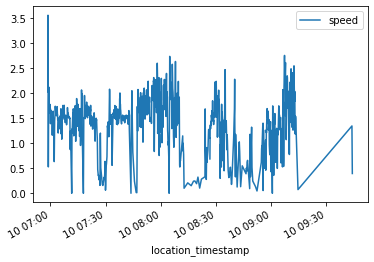

In [14]:
# UTC時間なのでグラフ表示する前にJST 時間にしておかないと見ずらい
query_sdf.plot(x='location_timestamp', y='speed')

#### matplotlib でグラフ表示（JST時間）
UTC から JST に変換してx:時間、y:スピード でグラフに表示してみます

In [15]:
# 参考
# https://note.nkmk.me/python-pandas-tz-convert-tz-localize/
# 1) to_datetime と dt.tz_convert を利用する
#query_sdf['location_timestamp_jst'] = pd.to_datetime(query_sdf['location_timestamp'], utc=True).dt.tz_convert('Asia/Tokyo')
# 次の警告がでる
# A value is trying to be set on a copy of a slice from a DataFrame.
#Try using .loc[row_indexer,col_indexer] = value instead
# 2) 警告の回避で明示的にDataFrameをcopy()する
query_sdf = query_sdf.copy()
query_sdf['location_timestamp_jst'] = pd.to_datetime(query_sdf['location_timestamp'], utc=True).dt.tz_convert('Asia/Tokyo')

In [16]:
# データ確認
query_sdf.tail()

,objectid,globalid,activity,altitude,app_id,battery_percentage,battery_state,course,device_id,floor,...,speed,vertical_accuracy,full_name,category,created_user,created_date,last_edited_user,last_edited_date,SHAPE,location_timestamp_jst
1576,17509,aa0b690b-2a14-44b9-816e-a020f939dc0e,2,55.000000,fieldmaps,78,1,134.404556,f9903507-6abb-4747-808a-44bf0029c57d,None,...,2.152627,1.626806,user@dev,None,user@devadmin,2022-01-10 09:11:49.628,user@devadmin,2022-01-10 09:11:49.628,"{""x"": 139.48831530000007, ""y"": 35.900036400000...",2022-01-10 18:08:33.538000+09:00
1577,17575,c4297527-2839-4307-ad4b-2be34a3c9065,2,50.100002,fieldmaps,78,1,138.148727,f9903507-6abb-4747-808a-44bf0029c57d,None,...,2.221127,1.349059,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.4904646000001, ""y"": 35.8979712000000...",2022-01-10 18:12:23+09:00
1578,17578,e4bdcd6c-f04f-4689-965d-7a166c082942,2,50.100002,fieldmaps,78,1,138.904175,f9903507-6abb-4747-808a-44bf0029c57d,None,...,2.364749,1.247079,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.4905658, ""y"": 35.897844400000054, ""s...",2022-01-10 18:12:33.999000+09:00
1579,17593,4023bcb6-4342-4bc9-b2e7-40357a8f80eb,2,49.700001,fieldmaps,78,1,52.776791,f9903507-6abb-4747-808a-44bf0029c57d,None,...,1.541021,1.315971,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.49102270000003, ""y"": 35.897557500000...",2022-01-10 18:13:19.519000+09:00
1580,17589,80d4aa20-ffb4-470a-8038-7e3d8d0a1fc3,2,50.400002,fieldmaps,78,1,107.498512,f9903507-6abb-4747-808a-44bf0029c57d,None,...,1.185419,1.238338,user@dev,None,user@devadmin,2022-01-10 09:24:51.675,user@devadmin,2022-01-10 09:24:51.675,"{""x"": 139.49085380000008, ""y"": 35.897423300000...",2022-01-10 18:13:08+09:00


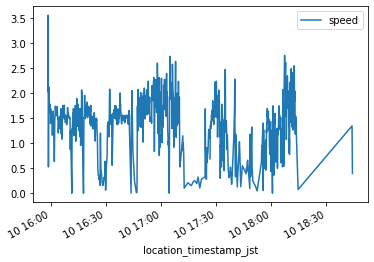

In [17]:
# JST 時間でグラフ表示（脳内で変換しなくてよくなった）
# speed が落ちている時間はどこかに寄った時間かな？
query_sdf.plot(x='location_timestamp_jst', y='speed')

#### マップを作成しTracks レイヤー を表示

MapView(layout=Layout(height='400px', width='100%'))


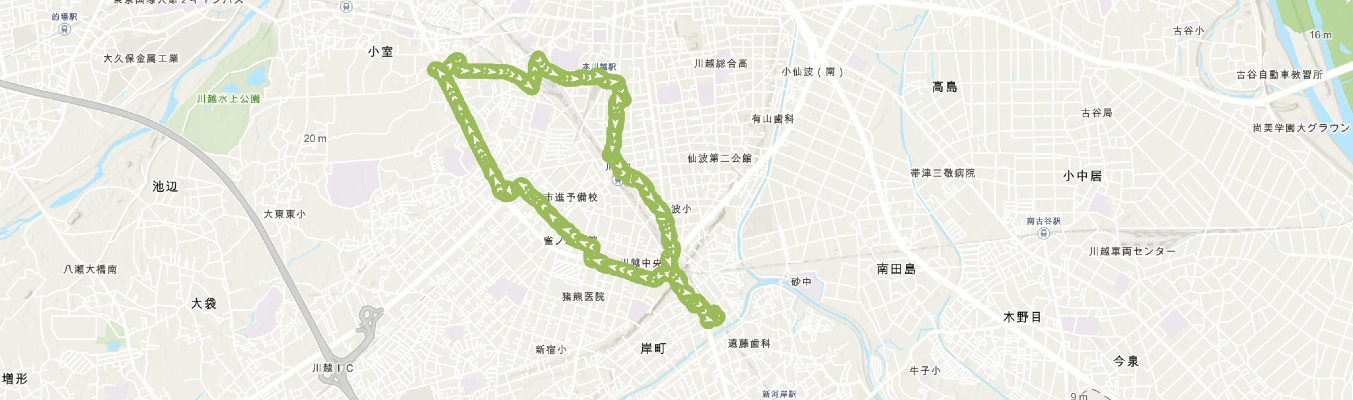

In [18]:
my_map = gis.map('埼玉県川越市')
my_map

In [19]:
# Tracks レイヤーを追加
my_map.add_layer(tracks)

↓ArcGIS API for Python のGitHub のWiki ページに書かれている[How to embed map images in your notebooks](https://github.com/Esri/arcgis-python-api/wiki/How-to-embed-map-images-in-your-notebooks) の方法を試し↓


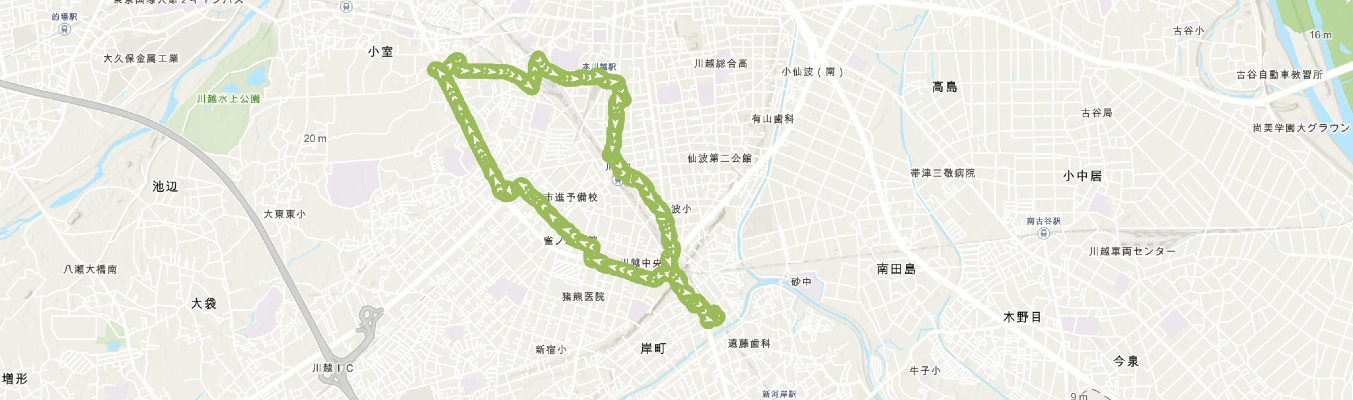

In [20]:
# 地図をノートブックで保存するために試した
my_map.take_screenshot()

### 3)' 別のアプローチ ; 計算したlocation_timestamp_jst を含むフィーチャ レイヤー（Feature Layer）として保存

In [21]:
# データの型を確認
query_sdf.dtypes

objectid                                       int64
globalid                                      object
activity                                       int64
altitude                                     float64
app_id                                        object
battery_percentage                             int64
battery_state                                  int64
course                                       float64
device_id                                     object
floor                                         object
horizontal_accuracy                          float64
location_source                               object
location_timestamp                    datetime64[ns]
session_id                                    object
signal_strength                               object
speed                                        float64
vertical_accuracy                            float64
full_name                                     object
category                                      

In [22]:
lyr = query_sdf.spatial.to_featurelayer(title='tracks_20220110', tags='tracks') # FeatureLayer として2022年1月10日のトラックを保存
lyr

<Item title:"tracks_20220110" type:Feature Layer Collection owner:user@devadmin>

### まとめ

本ノートブックでは、ArcGIS API for Python を使用して、次の異なるアプローチでフィーチャ レイヤー（Feature Layer）の保存を行ったサンプルです。

- 1) FieldMaps で取得したトラック データへアクセス

方法1  
- 2) FeatureLayer.query() を使用して特定の日時のデータをクエリ
- 3) 抽出したデータをフィーチャ レイヤー（Feature Layer）として保存

方法2  
- 2)' Pandas のDateFrame で特定の日時のデータを条件抽出
- 2)'' Spatially Enabled DataFrameを試す（Pandas のDateFrame での操作、グラフや地図表示）
- 3)' 抽出したデータをフィーチャ レイヤー（Feature Layer）として保存